I tried the Multiple Instance Learning [1] method in this project. This method is very useful for weakly annotated data and tiled medical images. Actually, this method is not very suitable for this type of binary classification problem and the sample size is very small (due to the sample size, the model has a superior performance in respect to F1 and ROC AUC Scores). However, I only wanted to try the multiple instance learning. 

<span style="color:#e74c3c;"> <b><i> MAIN GOAL: car image detection from a bag that contains both car and bike images </i></b> </span>

<b>If there is at least ONE CAR image, the bag has a positive label (1). If all images are BIKE in the bag, the bag has a negative label (0).</b>

<br>

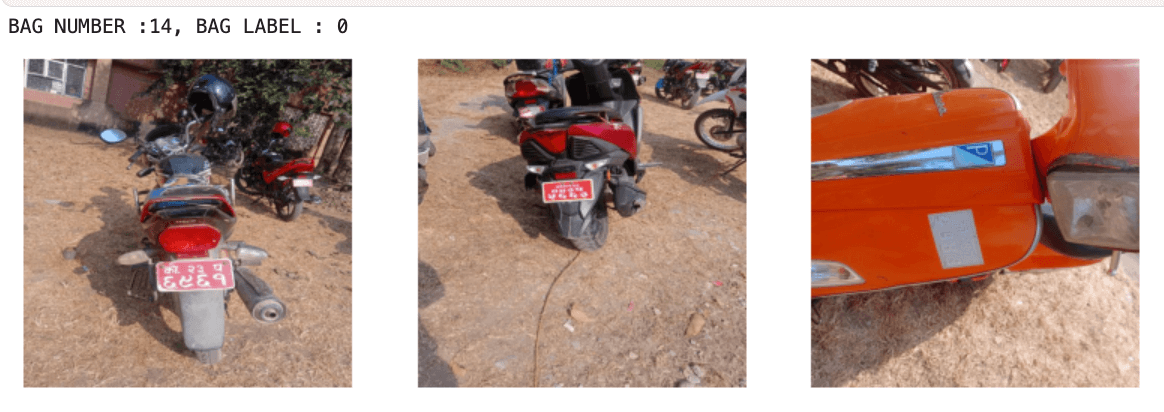

<i> <b>Figure 1:</b> A negative label bag example</i>

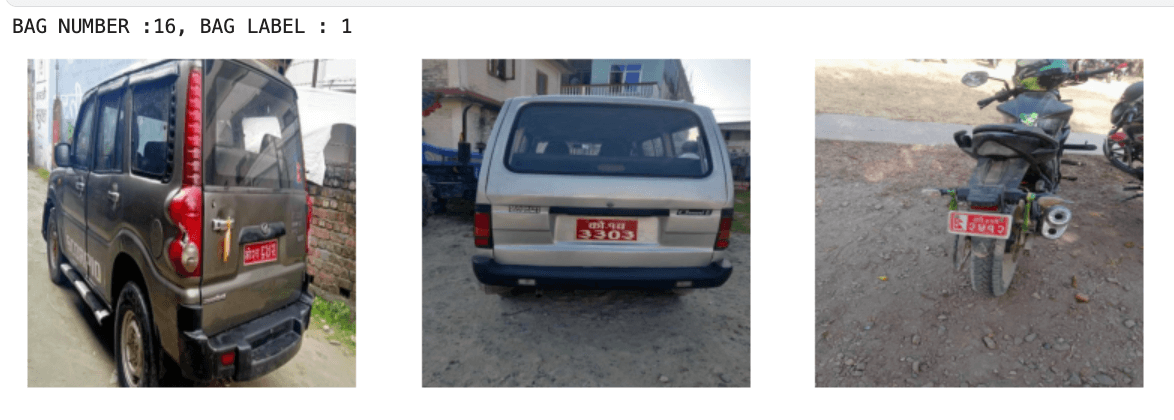

<i> <b>Figure 2:</b> A positive label bag example</i>


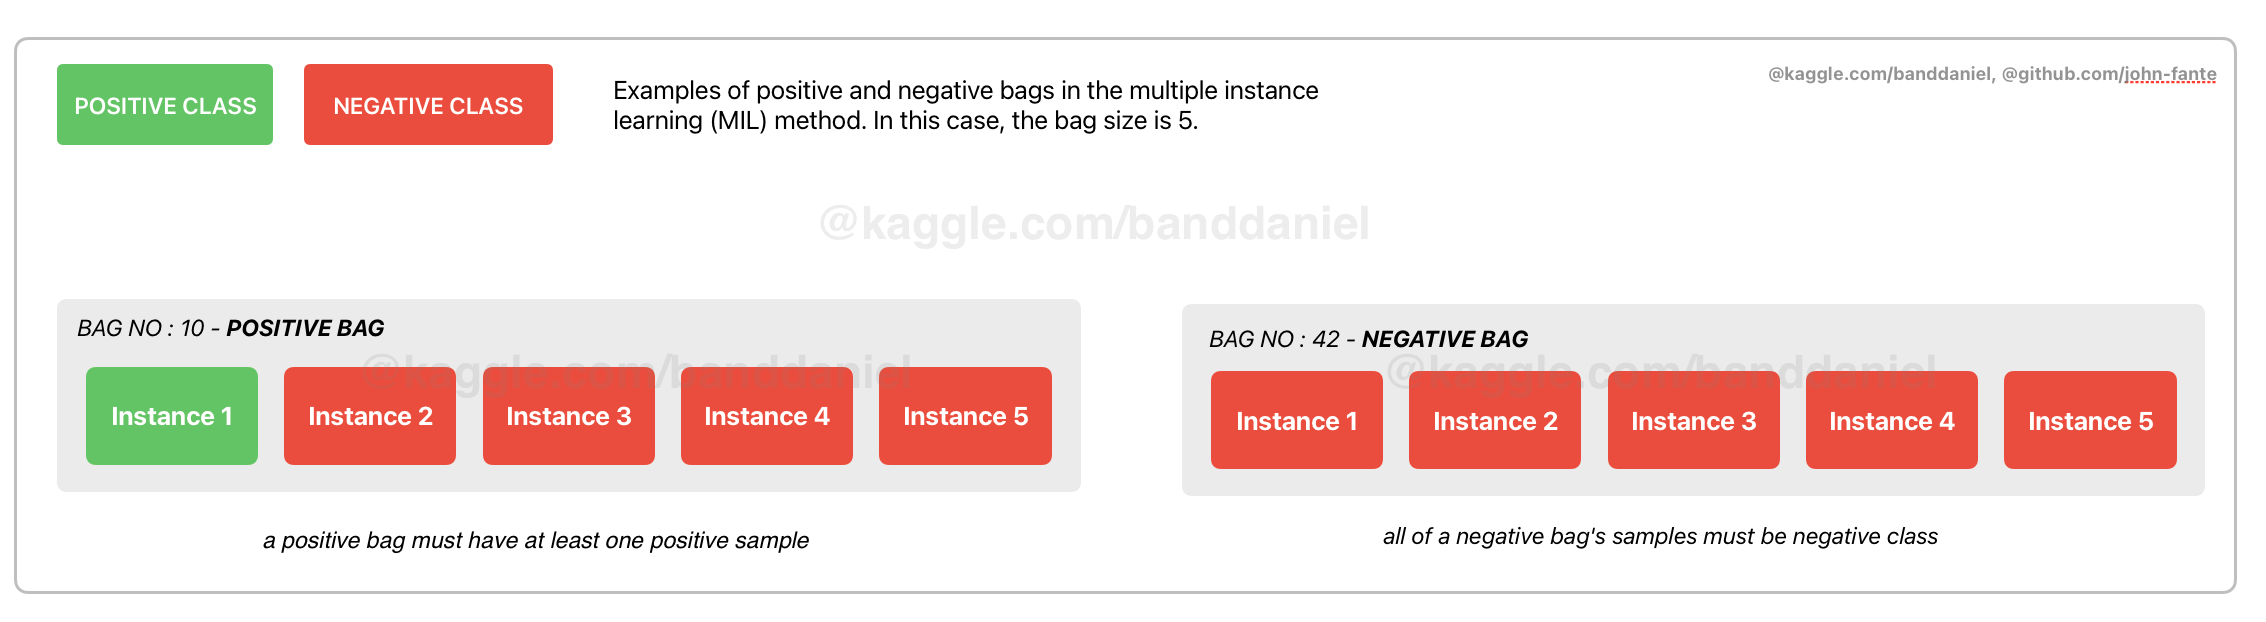
<i> <b>Figure 3:</b> Bags using in the Multiple Instance Learning</i>



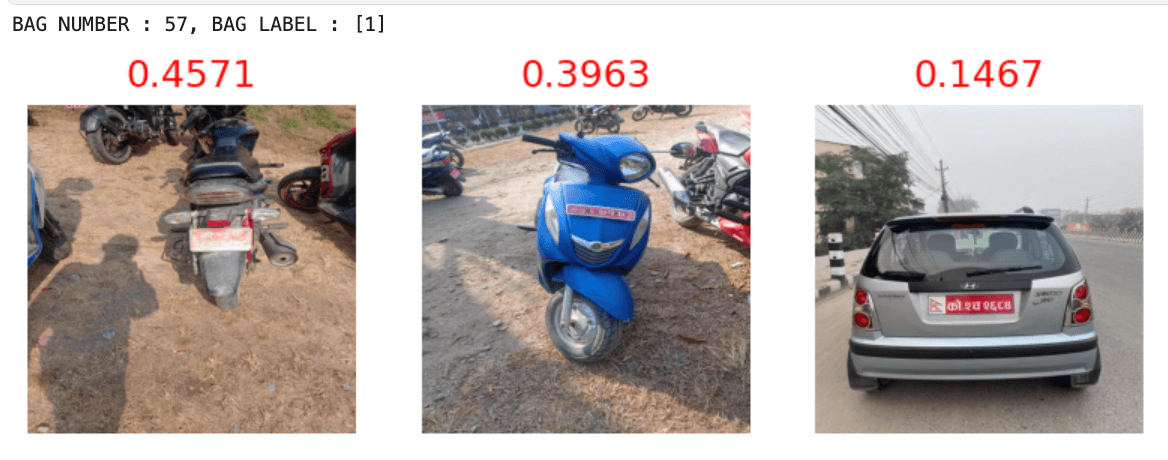

<i> <b>Figure 4:</b> Attention score results of a test bag   </i>



I have used the following methods.

* I used Gated Attention mechanism from the paper[2],
* Pre-trained ViT model for image features,
* Printing bags examples,
* 2 repetitive training steps (like 2-fold cross validation, but in this case we create new train and validation bags for each loop), at the end, averaging all the 2 loops test predictions,
* Rectified and recreated functions in this notebook [3],
* Printing attention scores, 



## My Another Projects
* [Molecule Activity, Deep Multiple Instance Learning](https://www.kaggle.com/code/banddaniel/molecule-activity-deep-multiple-instance-learning)
* [Satellite Image Captioning (ViT, Bi-LSTMs)](https://www.kaggle.com/code/banddaniel/satellite-image-captioning-vit-bi-lstms)
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Brain Tumor Detection w/Keras YOLO V8](https://www.kaggle.com/code/banddaniel/brain-tumor-detection-w-keras-yolo-v8)


## References
1. https://en.wikipedia.org/wiki/Multiple_instance_learning
2. Ilse, M., Tomczak, J. M., & Welling, M. (2018). Attention-based Deep Multiple Instance Learning (Version 4). arXiv. https://doi.org/10.48550/ARXIV.1802.04712
3. https://keras.io/examples/vision/attention_mil_classification/


In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from vit_keras import vit
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Multiply, concatenate
from tensorflow.keras.models import Model
from colorama import Fore, Back, Style
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay

SEED = 99
IMG_SIZE = 224, 224
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
def create_images_and_labels_lists(path):
    full_paths = []
    labels = []
    images = sorted(os.listdir(path))
    for i in images:
        full_paths.append(os.path.join(path, i))
        if i[:4] == 'Bike':
            labels.append(0)
        elif  i[:3] == 'car':
            labels.append(1)
        else:
            print('empty label')

        
    return full_paths, labels



train_images, train_labels = create_images_and_labels_lists('/kaggle/input/nepali-bike-and-car-images-with-annotations/Final Data/images/train')
train_data = pd.DataFrame({'image': train_images, 'label': train_labels})
train_data = train_data.sample(frac = 1, ignore_index = True, random_state = SEED)

test_images, test_labels = create_images_and_labels_lists('/kaggle/input/nepali-bike-and-car-images-with-annotations/Final Data/images/val')
test_data = pd.DataFrame({'image': test_images, 'label': test_labels})
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train data
# bike -> 0 , car -> 1
train_data.head()

,image,label
0,/kaggle/input/nepali-bike-and-car-images-with-...,0
1,/kaggle/input/nepali-bike-and-car-images-with-...,0
2,/kaggle/input/nepali-bike-and-car-images-with-...,1
3,/kaggle/input/nepali-bike-and-car-images-with-...,1
4,/kaggle/input/nepali-bike-and-car-images-with-...,1


# <span style="color:#e74c3c;"> ViT </span> Feature Extractor

In [4]:
# pre-trained ViT model and output has 768 features

vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', weights="imagenet21k+imagenet2012",
                        pretrained = True, include_top = True, pretrained_top = True)
    
feature_extractor = Model(inputs=vit_model.input, outputs=vit_model.layers[-2].output)

347502902/347502902 [==============================] - 1s 0us/step


In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(img, label):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label

In [6]:
# tf.data pipeline and datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(32)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(32)
                 .prefetch(AUTO))

In [7]:
# creating image features
train_img_features = feature_extractor.predict(train_dataset)
test_img_features = feature_extractor.predict(test_dataset)

8/8 [==============================] - 2s 245ms/step


# <span style="color:#e74c3c;"> Creating </span> Bags

In [8]:
#a function for creating bags
def create_bags(img_features, data_df, positive_class, bag_size):
    
    bags = []
    bag_labels = []
    bag_img_paths = []
    total_bags = img_features.shape[0] // bag_size
    
    count = 0
    
    for _ in range(total_bags):
        idx = np.random.choice(img_features.shape[0], bag_size, replace=False)
        instances_data = img_features[idx]
        instances_labels = data_df['label'][idx].values
        instances_paths = data_df['image'][idx].values

        bag_label = 0

        if positive_class in instances_labels:
            bag_label = 1
            count += 1


        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))
        bag_img_paths.append(instances_paths)


    print(f"Positive bags: {count}")
    print(f"Negative bags: {total_bags - count}")
    print("-"*20)


    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels), bag_img_paths)

In [9]:
def plot_a_bag(img_paths, bag_labels):
    idx = np.random.choice(len(img_paths), 1, replace=False)[0]
    bag_num = len(img_paths[idx])
    label_bag = bag_labels[idx][0]
    images = img_paths[idx]

    
    print("BAG NUMBER :" + str(idx) + ', BAG LABEL : ' + str(label_bag))

    fig, axs = plt.subplots(1,bag_num, dpi = 150)

    for i in range(bag_num):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].axis('off')

# <span style="color:#e74c3c;"> Creating </span> Test Bags

In [10]:
# positive class 1 for car images
# if there is at least ONE CAR image, the bag has a positive label (1). If all images are BIKE in the bag, the bag has a negative label.

test_bags, test_bags_labels, test_img_paths = create_bags(test_img_features,test_data,  positive_class = 1 ,bag_size = 3)

Positive bags: 75
Negative bags: 7
--------------------


BAG NUMBER :30, BAG LABEL : 0


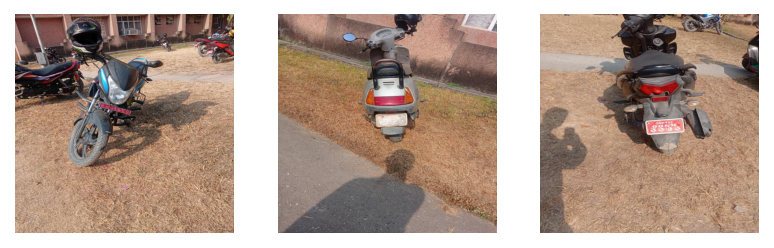

In [11]:
plot_a_bag(test_img_paths, test_bags_labels)

# <span style="color:#e74c3c;"> MIL Gated </span> Attention Layer

In [12]:
class MIL_Attention(Layer):
    def __init__(self, weight_params_dim, kernel_initializer1="glorot_uniform", kernel_initializer2="glorot_uniform",
                 kernel_initializer3="glorot_uniform", kernel_regularizer=None, use_gated=False, **kwargs):

        super(MIL_Attention, self).__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer1 = keras.initializers.get(kernel_initializer1)
        self.kernel_initializer2 = keras.initializers.get(kernel_initializer2)
        self.kernel_initializer3 = keras.initializers.get(kernel_initializer3)

        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer1
        self.w_init = self.kernel_initializer2
        self.u_init = self.kernel_initializer3

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self,input_shape):
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.v_init, name="v",
                                               regularizer=self.v_regularizer, trainable=True)

        self.w_weight_params = self.add_weight(shape=(self.weight_params_dim, 1), initializer=self.w_init, name="w",
                                               regularizer=self.w_regularizer, trainable=True)

        if self.use_gated:
            self.u_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.u_init, name="u",
                                                   regularizer=self.u_regularizer, trainable=True)
        else:
            self.u_weight_params = None
            self.input_built = True

    def call(self, inputs):
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        instances = tf.stack(instances)
        alpha = tf.nn.softmax(instances, axis = 0)
        return [alpha[i] for i in range(alpha.shape[0])]


    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        if self.use_gated:
            instance = instance * tf.math.sigmoid(tf.tensordot(original_instance,self.u_weight_params, axes=1 ))

        return tf.tensordot(instance, self.w_weight_params, axes = 1)
    
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "weight_params_dim" : self.weight_params_dim,
                "kernel_initializer1" : self.kernel_initializer1,
                "kernel_initializer2" : self.kernel_initializer2,
                "kernel_initializer3" : self.kernel_initializer3,
                "kernel_regularizer" : self.kernel_regularizer,
                "use_gated" : self.use_gated}

# <span style="color:#e74c3c;"> Deep MIL </span> Model

In [13]:
def create_mil_model(dense1_units, dense2_units, dense3_units, weight_params_dim , mlp_dropout_rate = 0.2):
    dense1 = Dense(dense1_units, activation = 'relu')
    dense2 = Dense(dense2_units, activation = 'relu')
    dense3 = Dense(dense3_units, activation = 'relu')


    inp1 = Input(shape =(768))
    dense1_1 = dense1(inp1)
    dense1_1 = Dropout(mlp_dropout_rate)(dense1_1)
    dense1_2 = dense2(dense1_1)
    dense1_3 = dense3(dense1_2)

    inp2 = Input(shape =(768))
    dense2_1 = dense1(inp2)
    dense2_1 = Dropout(mlp_dropout_rate)(dense2_1)
    dense2_2 = dense2(dense2_1)
    dense2_3 = dense3(dense2_2)


    inp3 = Input(shape =(768))
    dense3_1 = dense1(inp3)
    dense3_1 = Dropout(mlp_dropout_rate)(dense3_1)
    dense3_2 = dense2(dense3_1)
    dense3_3 = dense3(dense3_2)


    attention = MIL_Attention(weight_params_dim = weight_params_dim, kernel_regularizer = keras.regularizers.L2(0.09),
                              use_gated=True, name="attention")([dense1_3, dense2_3, dense3_3])

    mult1 = Multiply()([attention[0], dense1_3])
    mult2 = Multiply()([attention[1], dense2_3])
    mult3 = Multiply()([attention[2], dense3_3])
 

    conc = concatenate([mult1, mult2, mult3])

    out = Dense(2, activation = 'softmax')(conc)

    model = Model(inputs = [inp1, inp2, inp3], outputs = out)
    
    model.compile(optimizer = tf.optimizers.SGD(learning_rate = 0.0006, weight_decay = 0.03, momentum = 0.9),
              loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model

# <span style="color:#e74c3c;"> Training </span> Loop

In [14]:
# training cross validation loop
def create_train_loop(loop_num, epochs):
    
    test_evals = []
    test_preds = []
    
    for i in range(loop_num):
        print("\n------------------------------  Start Loop No: {0} ------------------------------ ".format(i+1))
        
        # splitting train and validation data then creating bags
        print("\n------ Created Bags (Train, Valid) ------")
        split_idx = 30
        train_bags, train_bags_labels, train_img_paths  = create_bags(train_img_features[split_idx:], train_data[split_idx:].reset_index(drop = True),1, 3)
        valid_bags, valid_bags_labels, valid_img_paths  = create_bags(train_img_features[:split_idx],train_data[:split_idx].reset_index(drop = True),1, 3)
        

        # creating the model
        mil_model = create_mil_model(dense1_units = 256, dense2_units = 128, dense3_units = 64, weight_params_dim = 128, mlp_dropout_rate = 0.2)
        
        my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience = 2),
                        tf.keras.callbacks.ModelCheckpoint("/kaggle/working/mil_deep.{0}_loop_weights.h5".format(i+1),
                                                           monitor="val_loss",mode="min", save_best_only=True, verbose=1)]
        
        # training
        hist = mil_model.fit(train_bags, train_bags_labels, validation_data = (valid_bags, valid_bags_labels),
                             batch_size = 1, epochs = epochs, callbacks = my_callbacks ) 
        
        # test evaluation and prediction
        test_eval = mil_model.evaluate(test_bags, test_bags_labels)
        pred = mil_model.predict(test_bags, verbose = 0)
        
        test_evals.append(test_eval)
        test_preds.append(pred)
        
        
    return test_evals, test_preds


# <span style="color:#e74c3c;"> Training </span> 

In [15]:
test_evals, test_preds = create_train_loop(2, epochs = 2)


------------------------------  Start Loop No: 1 ------------------------------ 

------ Created Bags (Train, Valid) ------
Positive bags: 228
Negative bags: 30
--------------------
Positive bags: 9
Negative bags: 1
--------------------
Epoch 1/2
257/258 [============================>.] - ETA: 0s - loss: 12.2818 - acc: 0.8833
Epoch 1: val_loss improved from inf to 9.08352, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
258/258 [==============================] - 4s 6ms/step - loss: 12.2692 - acc: 0.8837 - val_loss: 9.0835 - val_acc: 0.9000
Epoch 2/2
248/258 [===========================>..] - ETA: 0s - loss: 6.9518 - acc: 0.9355
Epoch 2: val_loss improved from 9.08352 to 5.17024, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
3/3 [==============================] - 0s 5ms/step - loss: 5.0437 - acc: 1.0000

------------------------------  Start Loop No: 2 ------------------------------ 

------ Created Bags (Train, Valid) ------
Positive bags: 224
Negative bags: 34

# <span style="color:#e74c3c;"> Test </span> Predictions

In [16]:
pred_ = np.mean(test_preds, axis = 0)
pred = np.argmax(pred_, axis = 1)

f1 = f1_score(test_bags_labels, pred)
roc = roc_auc_score(test_bags_labels, pred)

print("F1 Score: {0:.5f}".format(f1))
print("ROC Score: {0:.5f}".format(roc))

F1 Score: 1.00000
ROC Score: 1.00000


# <span style="color:#e74c3c;"> Classification </span> Report

In [17]:
clf = classification_report(test_bags_labels, pred)
print(clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        75

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



# <span style="color:#e74c3c;"> Confusion </span> Matrix

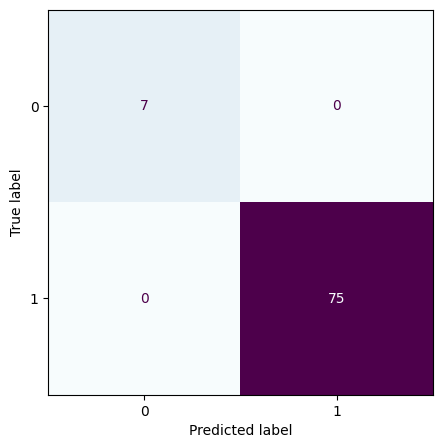

In [18]:
cm = confusion_matrix(test_bags_labels, pred)
cmd = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Attention </span> Performance


In [19]:
def print_attention_score(model, bags, bag_labels, img_paths, SEED = None):
    idx = np.random.default_rng(seed=SEED).permutation(len(bag_labels))[0]
    
    print("BAG NUMBER : " + str(idx) + ", BAG LABEL : " +str(bag_labels[idx]) )
    
    intermediate_model = keras.Model(model.input, model.get_layer("attention").output)
    intermediate_predictions = intermediate_model.predict(bags, verbose = 0)
    attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
    
    images = img_paths[idx]
    attentions = attention_weights[idx]
    fig, axs = plt.subplots(1,img_paths[idx].shape[0], dpi = 150)
    
    for i in range(images.shape[0]):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        att = attentions[i]
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title('{0:.4f}'.format(att), color = 'red')

In [20]:
model = create_mil_model(dense1_units = 256, dense2_units = 128, dense3_units = 64, weight_params_dim = 128, mlp_dropout_rate=0.2)
model.load_weights('/kaggle/working/mil_deep.2_loop_weights.h5')

BAG NUMBER : 57, BAG LABEL : [0]


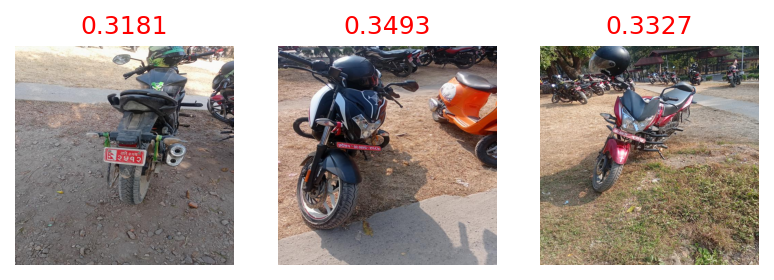

In [21]:
print_attention_score(model, test_bags,  test_bags_labels, test_img_paths, 10)

BAG NUMBER : 8, BAG LABEL : [1]


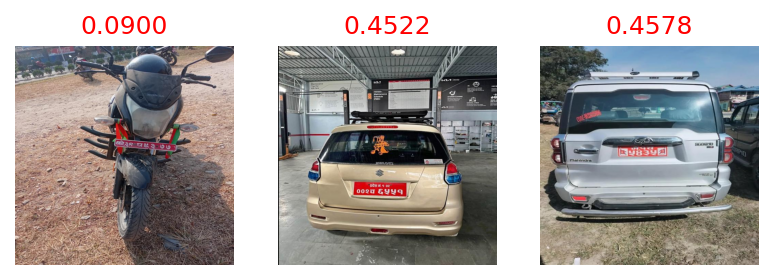

In [22]:
print_attention_score(model, test_bags,  test_bags_labels, test_img_paths, 1)